# 1. Image processing

## 1.1 Import packages

In [1]:
from skimage import io, filters, segmentation, morphology, measure, data, restoration, util
from skimage.color import rgb2gray
from skimage.util import crop
from skimage.filters import meijering, sato, frangi, hessian, apply_hysteresis_threshold
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.morphology import skeletonize
import numpy as np
import scipy.ndimage as ndi
import napari
import skimage as ski
import cv2
import sknw
import medpy
from medpy import filter
import networkx as nx

C:\App\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


## 1.2 Pipeline
Nettoyage background : rolling ball (radius = 15)

Amélioration des contrastes : enhancement CLAHE (source : https://stackoverflow.com/questions/39308030/how-do-i-increase-the-contrast-of-an-image-in-python-opencv)

Anisotropic smoothing

Amélioration des contours : meijering

Image binaire : hysteresis threshold 

Retirer les objets en fond (morphology.remove_small_objects, min_size = 5000)

Closing : binary_closing (disk = 5)

Squeletonisation

Graphe (source : https://github.com/Image-Py/sknw)

## 1.3 Import image

In [8]:
image = io.imread("../data/rhizophagus/12/3/R12_16_06_P05.jpg")

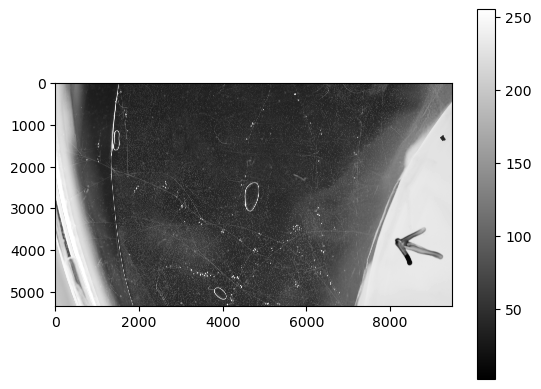

In [9]:
img = image[:, :, 1]

img = crop(img, crop_width = 10)

plt.imshow(img, cmap = "grey")
plt.colorbar()

plt.show()

## 1.4 Background

In [4]:
background = restoration.rolling_ball(img, radius = 15)

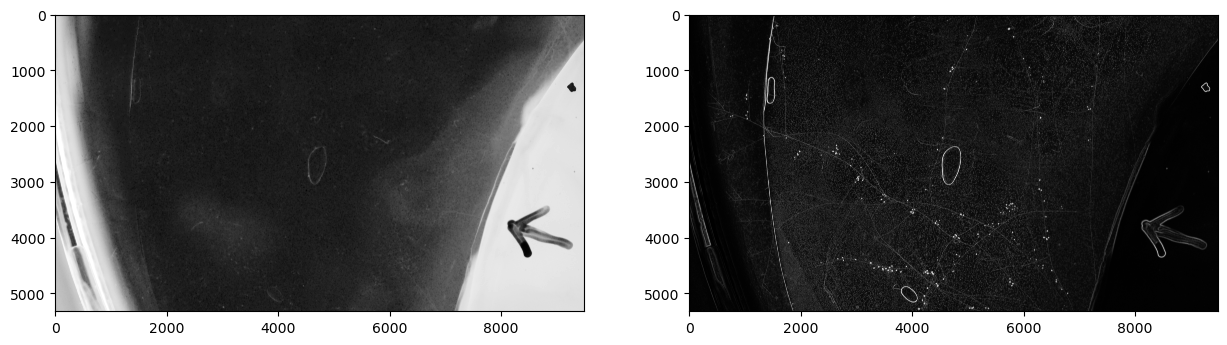

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 10))

ax1.imshow(background, cmap = "grey")

ax2.imshow(img - background, cmap = "grey")

In [6]:
img_wo_background = img - background

## 1.5 Contraste CLAHE

In [7]:
bgr_img = cv2.cvtColor(img_wo_background, cv2.COLOR_GRAY2BGR)

# converting to LAB color space
lab = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2LAB)
l_channel, a, b = cv2.split(lab)

# Applying CLAHE to L-channel
# feel free to try different values for the limit and grid size:
clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize = (8,8))
cl = clahe.apply(l_channel)

# merge the CLAHE enhanced L-channel with the a and b channel
limg = cv2.merge((cl,a,b))

# Converting image from LAB Color model to BGR color spcae
enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

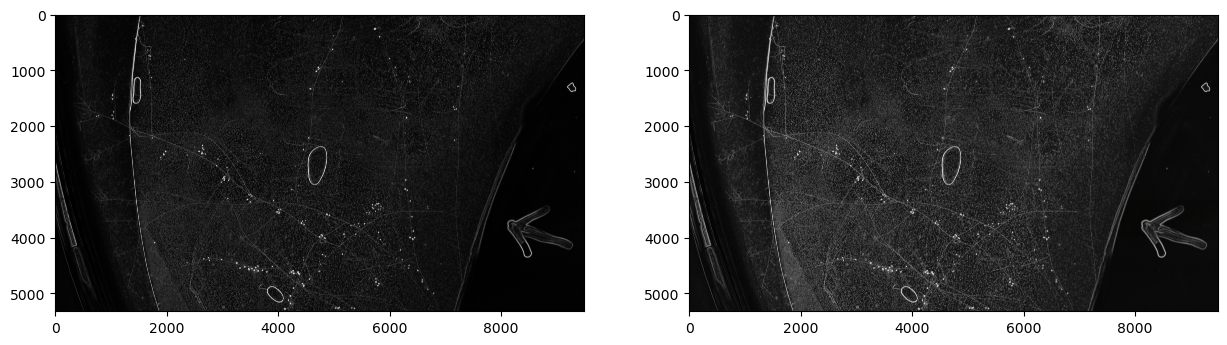

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 10))

ax1.imshow(img_wo_background, cmap = "grey")

ax2.imshow(enhanced_img , cmap = "grey")

In [9]:
enhanced_img = cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2GRAY)

## 1.6 Anisotropic smoothing

In [10]:
anisotropic_img = medpy.filter.smoothing.anisotropic_diffusion(enhanced_img, niter = 5, kappa = 50, gamma = 0.1)

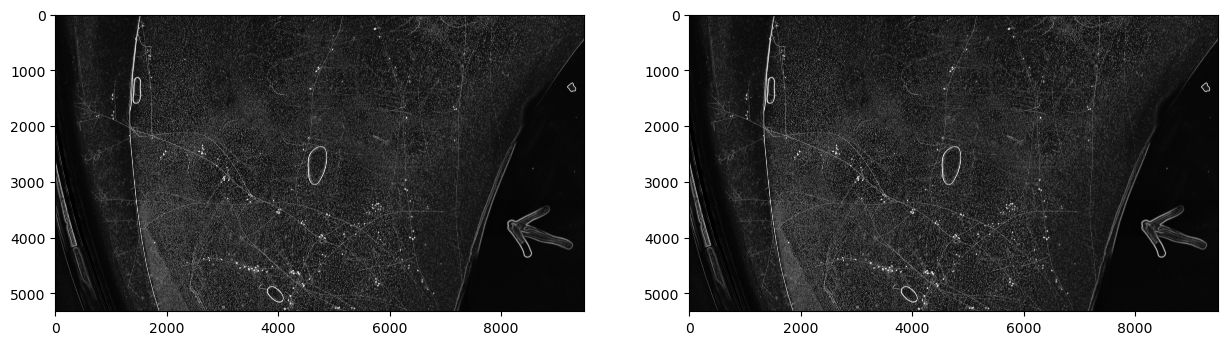

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 10))

ax1.imshow(enhanced_img, cmap = "grey")

ax2.imshow(anisotropic_img, cmap = "grey")

## 1.6 Edges enhancement 

### Meijering

In [12]:
img_ridge_enhanced = meijering(anisotropic_img, black_ridges = False, sigmas = range(1, 3))

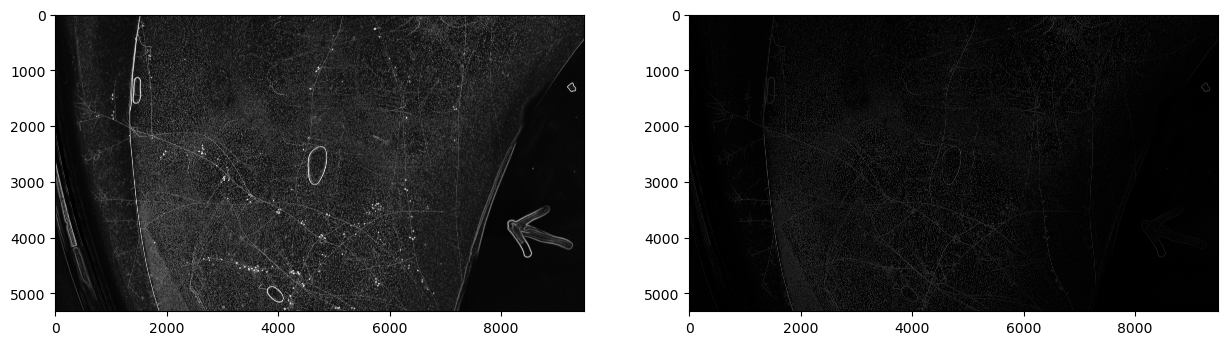

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 10))

ax1.imshow(enhanced_img, cmap = "grey")

ax2.imshow(img_ridge_enhanced, cmap = "grey")

(array([4.534872e+07, 2.427133e+06, 1.300806e+06, 7.464560e+05,
        4.038350e+05, 1.853050e+05, 6.484900e+04, 1.408400e+04,
        1.545000e+03, 8.300000e+01]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

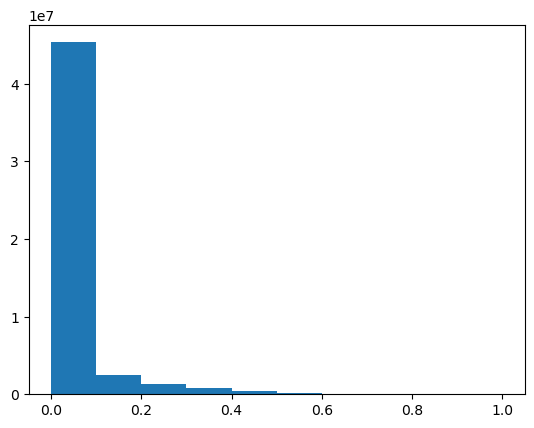

In [14]:
plt.hist(img_ridge_enhanced.flatten())

## 1.7 Binary image

In [15]:
img_binary = apply_hysteresis_threshold(img_ridge_enhanced, low = 0.05, high = 0.7)

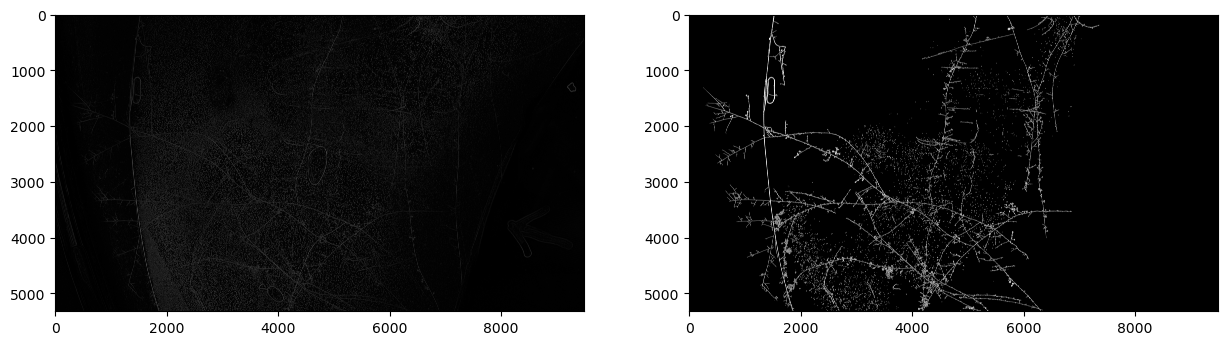

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 10))

ax1.imshow(img_ridge_enhanced, cmap = "grey")

ax2.imshow(img_binary, cmap = "grey")

## 1.8 Remove small objects 

In [17]:
img_clean = morphology.remove_small_objects(img_binary, min_size = 5000)

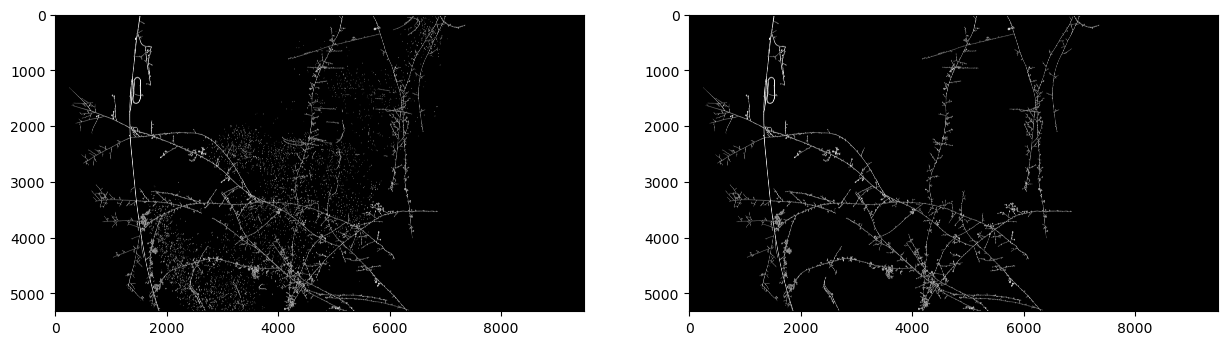

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 10))

ax1.imshow(img_binary, cmap = "grey")

ax2.imshow(img_clean, cmap = "grey")

## 1.9 Closing

In [19]:
footprint = morphology.disk(5)

img_closed = morphology.binary_closing(img_clean, footprint = footprint)

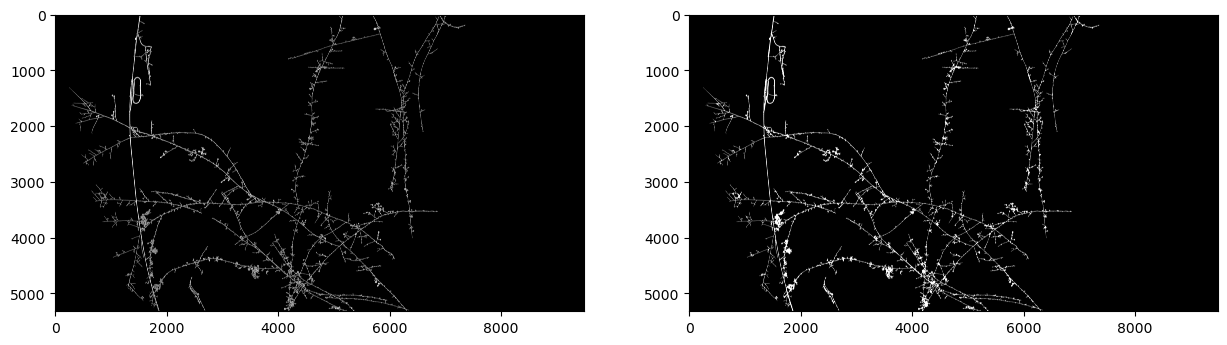

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 10))

ax1.imshow(img_clean, cmap = "grey")

ax2.imshow(img_closed, cmap = "grey")

## Etape supllémentaire : Gaussian blur

In [21]:
img_blur = ski.filters.gaussian(img_closed)

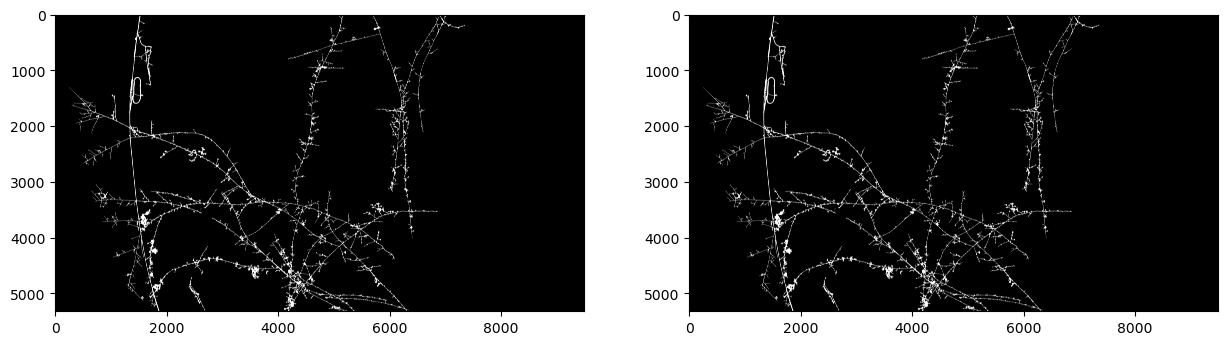

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

ax1.imshow(img_closed, cmap="grey")

ax2.imshow(img_blur, cmap="grey")

## 1.10 Skeleton

In [4]:
skeleton = skeletonize(img_closed)

In [5]:
skeleton_blur = skeletonize(img_blur) #skeletonisation avec le gaussian blur

NameError: name 'img_blur' is not defined

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 10))

ax1.imshow(img_closed, cmap = "grey")

ax2.imshow(skeleton, cmap = "grey")
ax1.set_aspect("equal")

# 2. Graph extraction

## 2.1 Méthode 1

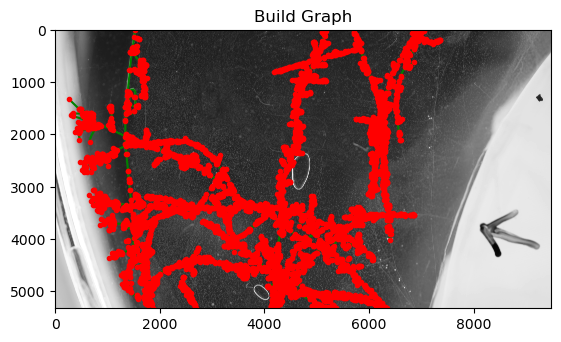

<Figure size 640x480 with 0 Axes>

In [10]:
# build graph from skeleton
graph = sknw.build_sknw(skeleton)

# draw image
plt.imshow(img, cmap = 'gray')

# draw edges by pts
for (s,e) in graph.edges():
    ps = graph[s][e]['pts']
    plt.plot(ps[:,1], ps[:,0], 'green')
    
# draw node by o
nodes = graph.nodes()
ps = np.array([nodes[i]['o'] for i in nodes])
plt.plot(ps[:,1], ps[:,0], 'r.')

# title and show
plt.title('Build Graph')
plt.show()
plt.savefig("graph_1")

# 3. Visualisation dans Napari

In [11]:
nodes_positions = np.array([graph.nodes[i]['o'] for i in graph.nodes], dtype = np.float32)

edges = []
for s, e in graph.edges():
    edge_points = np.array(graph[s][e]['pts'], dtype = np.float32)
    if edge_points.shape[0] > 1:  # If there are multiple points
        edge_points = edge_points[[0, -1], :]  # Use first and last points
    edges.append(edge_points)

In [12]:
viewer = napari.Viewer()

viewer.add_image(img, name = "raw image")
viewer.add_image(img_wo_background, name = "raw - background")
viewer.add_image(enhanced_img, name = "enhanced clahe")
viewer.add_image(img_ridge_enhanced, name = "ridge enhanced")
viewer.add_image(img_binary, name = "binary")
viewer.add_image(img_closed, name = "binary closing")
viewer.add_image(img_clean, name = "img clean")
viewer.add_image(skeleton, name = "skeleton")
# viewer.add_image(skeleton_blur, name = "skeleton blur")
# viewer.add_image(img_blur, name = "blur")

viewer.add_labels(skeleton, name = "skeleton", colormap = ["k", "w"])

viewer.add_points(nodes_positions, name = "nodes", size = 15, face_color = "blue", border_color = "gray")
viewer.add_shapes(edges, shape_type = 'line', edge_color = '#D3D3D3', edge_width = 8, name = "edges")

napari.run()

In [29]:
np.savez("img_process.npz", img_binary = img_binary, img_clean = img_clean, img_closed = img_closed, 
         img_ridge_enhanced = img_ridge_enhanced, img_wo_background = img_wo_background, 
         enhanced_img = enhanced_img, skeleton = skeleton, anisotropic_img = anisotropic_img)

In [3]:
img_process = np.load("img_process.npz")

for name in img_process.files:
    globals()[name] = img_process[name]

In [10]:
import os

os.makedirs("output_images", exist_ok=True)

for name in img_process.files:
    img = img_process[name]
    plt.imsave(f"output_images/{name}.png", img, cmap='gray' if img.ndim == 2 else None)

In [31]:
import pickle

# save graph object to file
pickle.dump(graph, open('graph.pickle', 'wb'))

In [32]:
graph_data = {
    "nodes": {i: {'o': tuple(map(float, d['o']))} for i, d in graph.nodes(data=True)},
    "edges": [((u, v), [tuple(map(float, p)) for p in data['pts']]) for u, v, data in graph.edges(data=True)]
}

with open("graphe_data.pkl", "wb") as f:
    pickle.dump(graph_data, f)

# 4. Fonction extract

In [33]:
def wo_background(img) :
    background = restoration.rolling_ball(img, radius = 15)
    img = img - background
    return img

In [34]:
def contraste(img) :
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l_channel, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize = (8,8))
    cl = clahe.apply(l_channel)
    img = cv2.merge((cl,a,b))
    img = cv2.cvtColor(img, cv2.COLOR_LAB2BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

In [35]:
def extract(photo, min_size = 5000, threshold_low = 0.05, threshold_high = 0.7, radius = 5) :
    # 1. Image
    img = io.imread(photo)
    img = img[:,:,1]

    # 2. Traitement 
    img = wo_background(img)  #retirer le fond
    img = contraste(img) #augmenter le contraste
    img = medpy.filter.smoothing.anisotropic_diffusion(img, niter = 5, kappa = 50, gamma = 0.1) #filtre anisotropique
    img = meijering(img, black_ridges = False, sigmas = range(1, 3)) #amélioration des edges
    img = apply_hysteresis_threshold(img, low = threshold_low, high = threshold_high) #image binaire
    img = morphology.remove_small_objects(img, min_size = min_size) #retirer les petits objets
    footprint = morphology.disk(radius = radius) #taille du cerle pour le closing
    img = morphology.binary_closing(img, footprint = footprint) #closing
    skeleton = skeletonize(img)

    # 3. Extraction du réseau
    G = sknw.build_sknw(skeleton)  

    return G